In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
])



In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 43178317.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47171220.34it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 47131845.82it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8990339.20it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
tensor([3, 0, 0, 7, 7, 1, 2, 2, 5, 6, 9, 0, 5, 2, 2, 2, 8, 5, 2, 0, 9, 8, 4, 0,
        9, 8, 6, 3, 6, 4, 2, 2, 5, 7, 7, 0, 1, 3, 8, 8, 7, 9, 3, 9, 4, 7, 6, 1,
        1, 6, 1, 3, 3, 2, 5, 3, 6, 3, 9, 5, 1, 9, 8, 3])


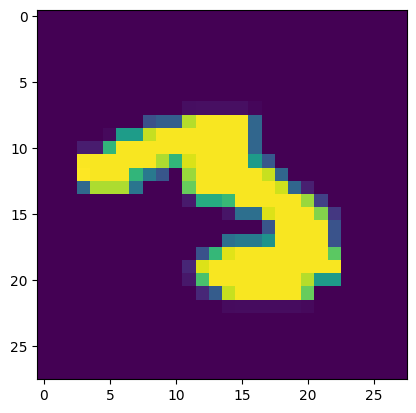

In [5]:
for image, label in train_loader:
    print(image.shape)
    image = image.permute(0, 2, 3, 1)
    print(image.view(64, -1).shape)
    plt.imshow(image[0])
    print(label)
    break

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 784)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        
        return x

In [8]:
x_g = torch.randn(1, 32)
x_d = torch.randn(1, 784)
generator = Generator(32)
discriminator = Discriminator()
output_g = generator(x_g)
output_d = discriminator(x_d)
output_g.shape, output_d.shape

(torch.Size([1, 784]), torch.Size([1, 1]))

In [9]:
generator_opt = optim.Adam(generator.parameters())
discriminator_opt = optim.Adam(discriminator.parameters())

In [24]:
epochs = 300
steps = 10
batch_size = 64
latent_dim = 32

device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)


for epoch in range(epochs):
    discriminator_loss = 0
    generator_loss = 0
    for images, labels in train_loader:
        batch_size = images.shape[0]
        noise = torch.randn(batch_size, latent_dim)
        real_data = images.view(batch_size, -1)
        noise, real_data = noise.to(device), real_data.to(device)
#         print(f'Shape of noise and real data is {noise.shape} and {real_data.shape}')
        
        generator_opt.zero_grad()
        discriminator_opt.zero_grad()
        generator.eval()
        
        generated_image = generator(noise)
#         print(f'Shape of generated image from noise is {generated_image.shape}')
        prediction_real = discriminator(real_data)
#         print(f'Shape of prediction of real from discriminator is {prediction_real.shape}')
        prediction_generated = discriminator(generated_image)
#         print(f'Shape of prediction of noise from discriminator is {prediction_generated.shape}')
        
        loss_discriminator = torch.sum(torch.log(prediction_real) + torch.log(1 - prediction_generated)) / batch_size
        discriminator_loss += loss_discriminator
#         print(f'Loss of discriminator is {loss_discriminator}')
        loss_discriminator.backward()
        discriminator_opt.step()

        generator_opt.zero_grad()
        discriminator_opt.zero_grad()
        discriminator.eval()

        generated_image = generator(noise)
#         print(f'Shape of generated image for training generator is {generated_image.shape}')
        loss_generator = torch.sum(torch.log(1 - discriminator(generated_image))) / batch_size
        generator_loss += loss_generator
        loss_generator.backward()
        generator_opt.step()
        
    print(loss_generator, loss_discriminator)

tensor(-0.7677, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.4991, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.7687, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.4984, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.7682, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.4990, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.7697, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.5064, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.7662, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.5163, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.7682, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.5055, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.7679, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.5043, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.7673, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.5005, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.7690, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.5277, device='cuda:0', grad_fn

KeyboardInterrupt: 

In [25]:
noise = torch.randn(1, latent_dim).to(device)
print(noise.shape)

generated = generator(noise)
print(generated.shape)

torch.Size([1, 32])
torch.Size([1, 784])


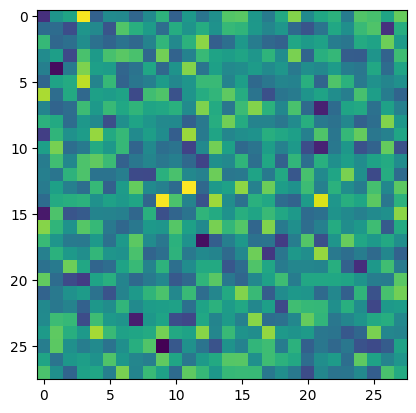

In [26]:
# plt.imshow(generated.view(1, 28, 28).cpu().detach().numpy())
plt.imshow(generated.view(1, 28, 28).cpu().detach().permute(1, 2, 0).numpy())